# CheXNet: Classification of Thoracic Diseases From Chest X-ray Images

## Table of Contents
1. [Introduction and Setup](#introduction)
2. [Prepare the Dataset](#dataset)
3. [Create the Model](#model)
4. [Train the Model](#fine_tunng)
5. [Evaluate the Model](#evaluate)
7. [Inference Examples](#inference-examples)
6. [Training on Multiple Gaudis](#multi-gaudi)

<a id='Introduction'></a>
## Introduction

This notebook shows how to fine-tune [CheXNet](https://arxiv.org/abs/1711.05225v3) on a Gaudi system. CheXNet is a 121-layer DenseNet model trained on [ChestX-ray14](https://paperswithcode.com/dataset/chestx-ray14) dataset. It takes chest X-ray images as input and performs multi-label classification to detect 14 different thoracic diseases. 
The DenseNet121 backbone of this model is pretrained on the ImageNet dataset. We add a classification layer and use ChestX-ray14 dataset to fine-tune the model for this application.
We will show how easy and fast it is to train this model on a Gaudi system. We will also show how you can further accelerate the training using multiple Gaudis.

The following steps presented in this tutorial are summarized in this pipeline:

![pipeline.svg](pipeline.svg)

This notebook is meant to demonstrate the entire end-to-end model development process. 
However, for the sake of practicability, in what follows, we only cover training on a single Gaudi device.
The instructions for distributed trainig on multiple devices are provided in the last section.

## Setup

This notebook runs on a Gaudi system with SynapseAI and Gaudi drivers installed. Please refer to the [installation guide](https://docs.habana.ai/en/latest/Installation_Guide/index.html) for more information.


### Install dependencies

In [1]:
#%pip install numpy Pillow scikit-learn pandas torch torchvision matplotlib tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a id='import'></a>
## Import Public Modules

In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
%matplotlib inline

### Import Habana-related Modules

In [4]:
#########from habana_frameworks.torch.utils.library_loader import load_habana_module
#########import habana_frameworks.torch.core as htcore
#########import habana_frameworks.torch.distributed.hccl
#########load_habana_module()
#########device = torch.device('hpu')
device = torch.device('cpu')

<a id='dataset'></a>
## Prepare the Dataset 

ChestX-ray dataset comprises 112,120 frontal-view X-ray images of 30,805 unique patients with the text-mined fourteen disease image labels, where each image can have multi-labels. The thoracic pathologies covered in the data set are:
    
1. Atelectasis	肺塌陷
2. Cardiomegaly	心臟肥大
3. Effusion	肺積水
4. Infiltration	肺浸潤
5. Mass	腫塊
6. Nodule	結節
7. Pneumonia	肺炎
8. Pneumothorax	氣胸
9. Consolidation	肺實質化
10. Edema	水腫
11. Emphysema	氣腫
12. Fibrosis	纖維化
13. Pleural_Thickening	胸膜增厚
14. Hernia	肺疝氣

The dataset is available at https://nihcc.app.box.com/v/ChestXray-NIHCC. Please download and extract the `images` folder as well as the `Data_Entry_2017_v2020.csv`, `train_val_list.txt`, and `test_list.txt` files to your working directory. 

Run the script `preprocess_data.py` to generate the split files with labels. This will create a new folder called `labels` which contains the `train_list.txt` and `test_list.txt`.

### Create the dataset class
In the cell below we use data primitive `torch.utils.data.Dataset` to create `ChestXrayData` class for loading and processing training and test data.

In [5]:
class ChestXrayData(torch.utils.data.Dataset):
    def __init__(self, data_dir, image_list_file, transform=None):
        '''
        data_dir: path to image directory.
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        '''
        image_names = []
        labels = []
        with open(image_list_file, 'r') as f:
            for line in f:
                items = line.split()
                image_name = os.path.join(data_dir, items[0])
                image_names.append(image_name)
                label = [int(i) for i in items[1:]]
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        '''
        index: the index of item
        Return image and its labels
        '''
        return self.get_sample(index, self.transform)

    def get_sample(self, index, transform):
        '''
        index: the index of item
        transform: the transform used on item
        Return transformed image and its labels
        '''
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        
        if transform:
            image = transform(image)
        return image, torch.FloatTensor(label), image_name

    def __len__(self):
        return len(self.image_names)

In the next step, we compose all image tranformations (resize, normalize, casting to tensor) together in `torchvision.transforms.Compose` class and pass it to ChestXrayData class.

In [6]:
# We assume the ChestX-ray14 dataset downloaded in local storage.
# ./images - directory containing image files
# ./labels - directory containing .txt files with list of image names and their respective
#            ground truth labels on every row

data_dir  = 'images/images'
label_dir = 'labels'

# Each line contains the filename of an x-ray image and respective labels
train_image_list_file = label_dir + '/train_list.txt'
test_image_list_file  = label_dir + '/test_list.txt'
batch_size            = 32

# preprocessing for visualization
resize_transform = transforms.Compose([
    transforms.Resize(256),                                     
    transforms.ToTensor()                                       
    ])

# preprocessing for model input
normalize_transform = transforms.Compose([
    resize_transform,                                       
    transforms.Normalize(                          
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
        )                                                    
    ])

# train data set object
train_data = ChestXrayData(
    data_dir=data_dir,                
    image_list_file=train_image_list_file,
    transform=normalize_transform,
    )

# batch by batch iterator on train data
train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    num_workers=0,
    pin_memory=True,
    drop_last=True
) 

# test data set object
test_data = ChestXrayData(
    data_dir=data_dir,
    image_list_file=test_image_list_file,
    transform=normalize_transform,
    )

# batch by batch iterator on test data
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    )

print('Train dataset contains %d batches and %d images' % (len(train_loader), len(train_data)))
print('Test dataset contains %d batches and %d images'  % (len(test_loader),  len(test_data)))

Train dataset contains 2703 batches and 86524 images
Test dataset contains 800 batches and 25596 images


Now, we create a list containing disease names to map image labels.

In [7]:
#!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download


In [8]:
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

In [9]:
CLASS_COUNT = 14
CLASS_NAMES = [
    'Atelectasis-肺塌陷',
    'Cardiomegaly-心臟肥大',
    'Effusion-肺積水',
    'Infiltration-肺浸潤',
    'Mass-腫塊',
    'Nodule-結節',
    'Pneumonia-肺炎',
    'Pneumothorax-氣胸',
    'Consolidation-肺實質化',
    'Edema-水腫',
    'Emphysema-氣腫',
    'Fibrosis-纖維化',
    'Pleural_Thickening-胸膜增厚',
    'Hernia-肺疝氣'
    ]

Let's visualize a few X-ray images with their disease labels.

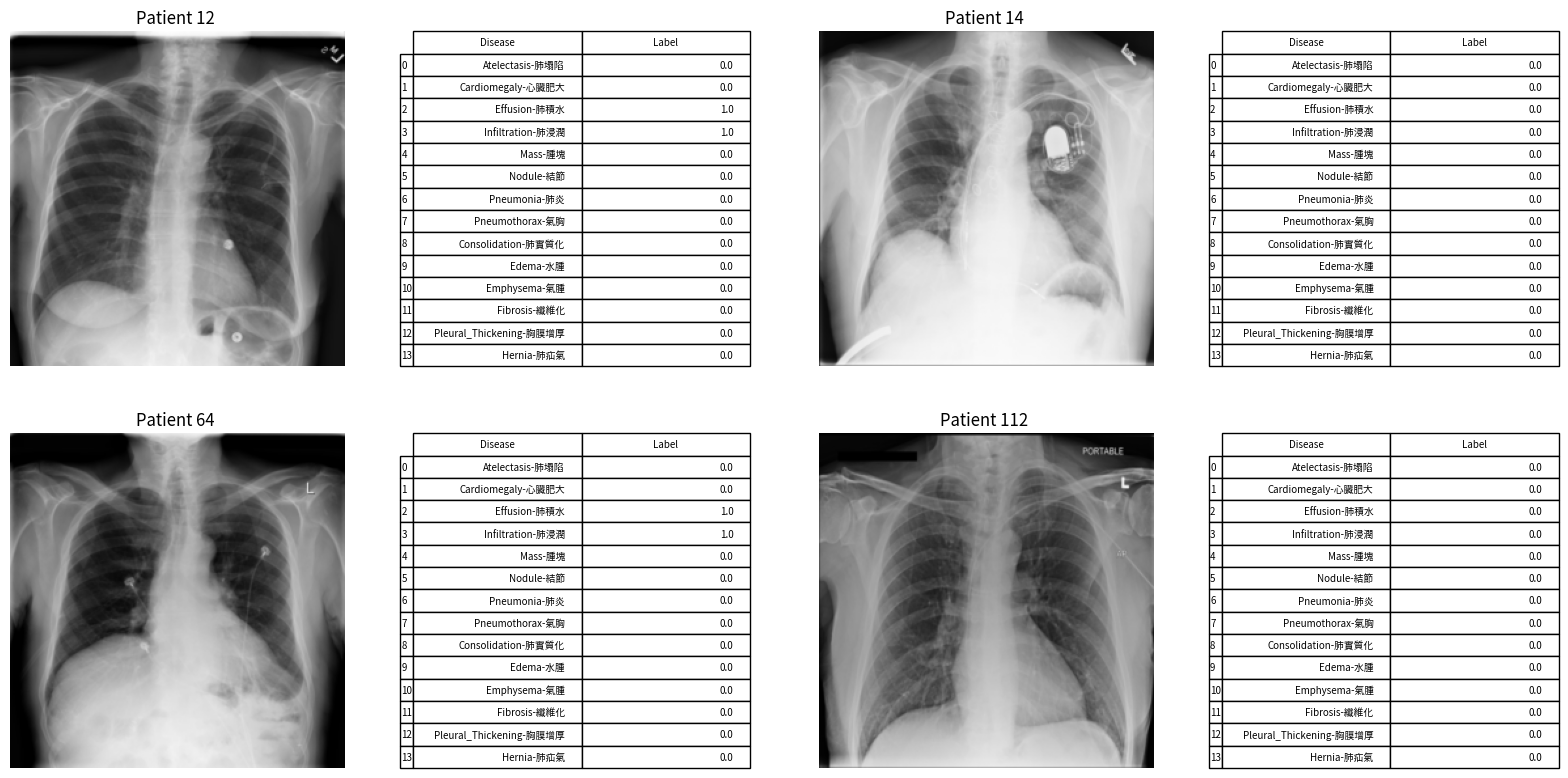

In [10]:

patient_id_list = [12, 14, 64, 112]
fig = plt.figure(figsize=(20, 20))

for plot_id, patient_id in enumerate(patient_id_list):
    image, label, _ = train_data.get_sample(patient_id, resize_transform)
    print_img = np.transpose(image.numpy(), (1, 2, 0))
    y_true = label.numpy()
    df = pd.DataFrame({'Disease': CLASS_NAMES, 'Label': y_true})
    
    ax1 = fig.add_subplot(len(patient_id_list), len(patient_id_list), 2*plot_id+1)
    title = 'Patient %d ' % (patient_id)
    ax1.set_title(title)
    ax1.axis('off')
    plt.imshow(print_img)
    
    ax2 = fig.add_subplot(len(patient_id_list), len(patient_id_list), 2*plot_id+2)
    ax2.axis('off')
    table = ax2.table(cellText=df.values, rowLabels=df.index, bbox=[0, 0, 1, 1], colLabels=df.columns)
    table.set_fontsize(12)
    
plt.show()

<a id='model'></a>
## Create the Model

Here, we add a linear classification layer with 14 logit outputs (with no activation function) on the top of the `torchvision.models.densenet121` backbone model. Each classifier output represents a disease.

For the backbone initialization, we use the ImageNet weights from the checkpoint `torchvision.models.DenseNet121_Weights.IMAGENET1K_V1`.

In [11]:
class CheXNet(nn.Module):
    def __init__(self, out_size):
        super(CheXNet, self).__init__()
        self.densenet121 = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)
        num_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_features, out_size)

    def forward(self, x):
        x = self.densenet121(x)
        return x

<a id='fine_tunng'></a>
## Train the Model

Now, we perform transfer learning using the previously loaded weights as initial values for further fine-tuning with our dataset.

In [12]:
net = CheXNet(CLASS_COUNT)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

#### Imbalanced Training

In medical domain, we typically deal with imbalanced data, where negative datapoints by far exceed the positive ones in numbers of occurrence. To cope with that inherent imbalanced distribution, we need to quantify it. The following line calculates the prior odds over the training data for each disease. The users themselves can verify that the odds over the test data are very similar to the train data.

In [13]:
pos_weight = pd.read_csv('labels/train_list.txt', sep=' ', header=None, usecols=range(1, 1+CLASS_COUNT))\
    .apply(lambda x: (x.size - x.sum()) / x.sum())
pos_weight = torch.tensor(pos_weight.values).float().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [14]:
# num_epoch       = 1
# log_window_size = 1000    # number of steps till next log
# train_loss      = 0
# accuracy        = 0
# step            = 0
# import time
# start_time = time.time()
# net.train()
# for epoch in range(num_epoch):
#     for (images, labels) in tqdm(train_loader, desc='Epoch %d/%d' %(epoch+1, num_epoch)):
#         images = images.to(device)
#         labels = labels.to(device)
#         logits = net(images)
#         loss = criterion(logits, labels)
        
#         optimizer.zero_grad()
#         loss.backward()
#         ##################htcore.mark_step()
#         optimizer.step()
#         ##################htcore.mark_step()

#         y_true = labels.detach().cpu()
#         y_pred = (logits.detach().cpu() > 0.0).float()
        
#         accuracy += ( accuracy_score( y_true.reshape(-1), y_pred.reshape(-1) ) ) * len(images) # weighted accuracy
#         train_loss += loss.item() * len(images)
#         if step % log_window_size == log_window_size - 1:
#             count_window_datapoints = (log_window_size - 1) * batch_size + len(images)
#             print(f'Loss: {train_loss / count_window_datapoints }, Accuracy: { accuracy / count_window_datapoints })')
#             accuracy = 0
#             train_loss = 0

#         step += 1    
# print("Training time: ",time.time() - start_time)    


In [15]:
#torch.save(net, 'chexnet_finetuned_1_ep.pth')

<a id='evaluate'></a>
## Evaluate the Model on Test Data

In [16]:
#net.load_state_dict(torch.load('chexnet_finetuned_1_ep.pth', map_location='cpu'))
net = CheXNet(CLASS_COUNT)
net = net.to(device)
net = torch.load('chexnet_finetuned.pth')

In [17]:
# net.eval()

# accuracy    = 0
# test_loss   = 0
# image_count = 0

# with torch.no_grad():
#     loop = tqdm(test_loader, total=len(test_loader), leave=False)
#     loop.set_description('Evaluation: ')
    
#     for (images, labels) in loop:
#         images = images.to(device)
#         labels = labels.to(device)
#         logits = net(images)
#         loss = criterion(logits, labels)

#         y_true = labels.detach().cpu()
#         y_pred = (logits.detach().cpu() > 0).float()
       
#         accuracy += accuracy_score( y_true.reshape(-1), y_pred.reshape(-1) ) * len(images)
#         test_loss += loss.item() * len(images)
#         image_count += len(images)

# test_loss /= image_count
# accuracy  /= image_count
# print(f"Test Error Result: \n Accuracy: %.4f, Loss: %.4f  \n" % (accuracy, test_loss))

In [18]:
#https://github.com/berneylin/chexnet/blob/master/generate_heatmap_cpu.py
from densenet_models import DenseNet121
import numpy as np
from PIL import Image
import cv2
import torch
import torchvision.transforms as transforms

class HeatMapGenerator:
    def __init__(self):
        self.nn_architecture = 'DENSE-NET-121'
        self.pre_checkpoint = 'model0122.pth'
        self.num_classes = 14
        self.trans_crop = 256
        self.nn_is_pre_trained = True
        self.class_names = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
               'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
               'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

        # initialize network model with pre-trained weights
        self.network_model = DenseNet121(self.num_classes, self.nn_is_pre_trained)

        self.network_model = torch.nn.DataParallel(self.network_model)
        model_checkpoint = torch.load(self.pre_checkpoint, map_location='cpu')
        self.network_model.load_state_dict(model_checkpoint['state_dict'])

        # only need convolution layers' weights to generate heat map
        self.cam_model = self.network_model.module.dense_net_121.features
        self.cam_model.eval()  # set network as evaluation model without BN & Dropout
        self.network_model.eval()  # set network as evaluation model without BN & Dropout

        # CPU runtime, annotate below line to disable cuda
        # self.network_model.cuda()

        # select the last convolution layers' weights as weights of CAM
        self.weights = list(self.cam_model.parameters())[-2]

        # initialize the images transform sequence
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transform_list = list()
        transform_list.append(transforms.Resize(self.trans_crop))
        transform_list.append(transforms.ToTensor())
        transform_list.append(normalize)
        self.transform_sequence = transforms.Compose(transform_list)

    def generator(self, path_to_raw_image, trans_crop=None):
        path_to_output_image ='./output'
        if trans_crop is None:
            trans_crop = self.trans_crop

        # load image, transform, convert
        image_data = Image.open(path_to_raw_image).convert('RGB')
        image_data = self.transform_sequence(image_data)
        image_data = image_data.unsqueeze_(0)

        var_image = torch.autograd.Variable(image_data)

        with torch.autograd.no_grad():
            var_output = self.cam_model(var_image)
            var_prediction = self.network_model(var_image)

        # output predicted result
        predict_probability = np.max(var_prediction.data.numpy())
        predict_label = self.class_names[np.argmax(var_prediction.data.numpy())]
        #print(predict_label, predict_probability)

        # start generating heat map
        heat_map = None
        for i in range(len(self.weights)):
            tmp_map = var_output[0, i, :, :]
            if i == 0:
                heat_map = self.weights[i] * tmp_map
            else:
                heat_map += self.weights[i] * tmp_map

        # convert torch tensor to numpy nd-array
        heat_map = heat_map.data.numpy()

        # blend raw image and heat map
        raw_img = cv2.imread(path_to_raw_image, 1)
        raw_img = cv2.resize(raw_img, (trans_crop, trans_crop))

        cam = heat_map / np.max(heat_map)
        cam = cv2.resize(cam, (trans_crop, trans_crop))
        heat_map = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

        output_img = heat_map * 0.5 + raw_img
        path_to_output_image = 'output/heatmap.png'
        # save heat map image
        cv2.imwrite(path_to_output_image, output_img)
        return path_to_output_image

<a id='inference-examples'></a>
## Inference Examples

Now, let's visualize some of the test samples and see their predicted output. 

In the cell below, the images are visualized with the corresponding ground-truth disease labels, as well as with the model outputs in terms of the prediction probability, and the binary decision based on thresholded prediction probability.

In [19]:
def inference():
    net = torch.load('chexnet_finetuned.pth')
    net.eval()
    fig = plt.figure(figsize=(25, 25))
    patient_ids = [1,18,25,26] # arbitrary patient ids picked up as inference examples
    for plot_id, inference_id in enumerate(patient_ids):
        # Inference
        image, label, image_name = train_data.get_sample(inference_id, normalize_transform)
        image = image.unsqueeze(0).to(device)
        logit = net(image).to(torch.device('cpu')).detach()
        probability = torch.sigmoid(logit).squeeze().numpy()
        out = (probability > 0.5) # Imbalanced training has been taken into consideration.
        
        # Visualisation
        print_img, _, image_name = train_data.get_sample(inference_id, resize_transform) # Image without normalization
        print_img = np.transpose(print_img.numpy(), (1, 2, 0))
        y_true = label.numpy()
    
        # Heatmap
        heat_map_generator = HeatMapGenerator()
        heat_img_path = heat_map_generator.generator(image_name)
        heat_img = mpimg.imread(heat_img_path)
            
        df = pd.DataFrame({'Disease': CLASS_NAMES, 'Label': y_true, 'Prediction probability': probability, 'Decision': out})
        df.update(df[['Decision']].applymap('{:,.1f}'.format))
        df.update(df[['Prediction probability']].applymap('{:,.2f}'.format))
    
        ax1 = fig.add_subplot(len(patient_ids), len(patient_ids), 4 * plot_id+1)
        title = 'Patient %d ' % (plot_id)
        ax1.set_title(title)
        ax1.axis('off')
        plt.imshow(print_img)
        
        ax2 = fig.add_subplot(len(patient_ids), len(patient_ids), 4 * plot_id+2)
        ax2.axis('off')
        table = ax2.table(cellText = df.values, rowLabels = df.index, bbox=[0, 0, 1, 1], colLabels=df.columns)
        table.auto_set_font_size(False)
        table.auto_set_column_width(True)
        table.set_fontsize(8)
    
        ax3 = fig.add_subplot(len(patient_ids), len(patient_ids), 4 * plot_id+3)
        title = 'Patient %d heatmap' % (plot_id)
        ax3.set_title(title)
        ax3.axis('off')
        plt.imshow(heat_img)
        
    plt.show()

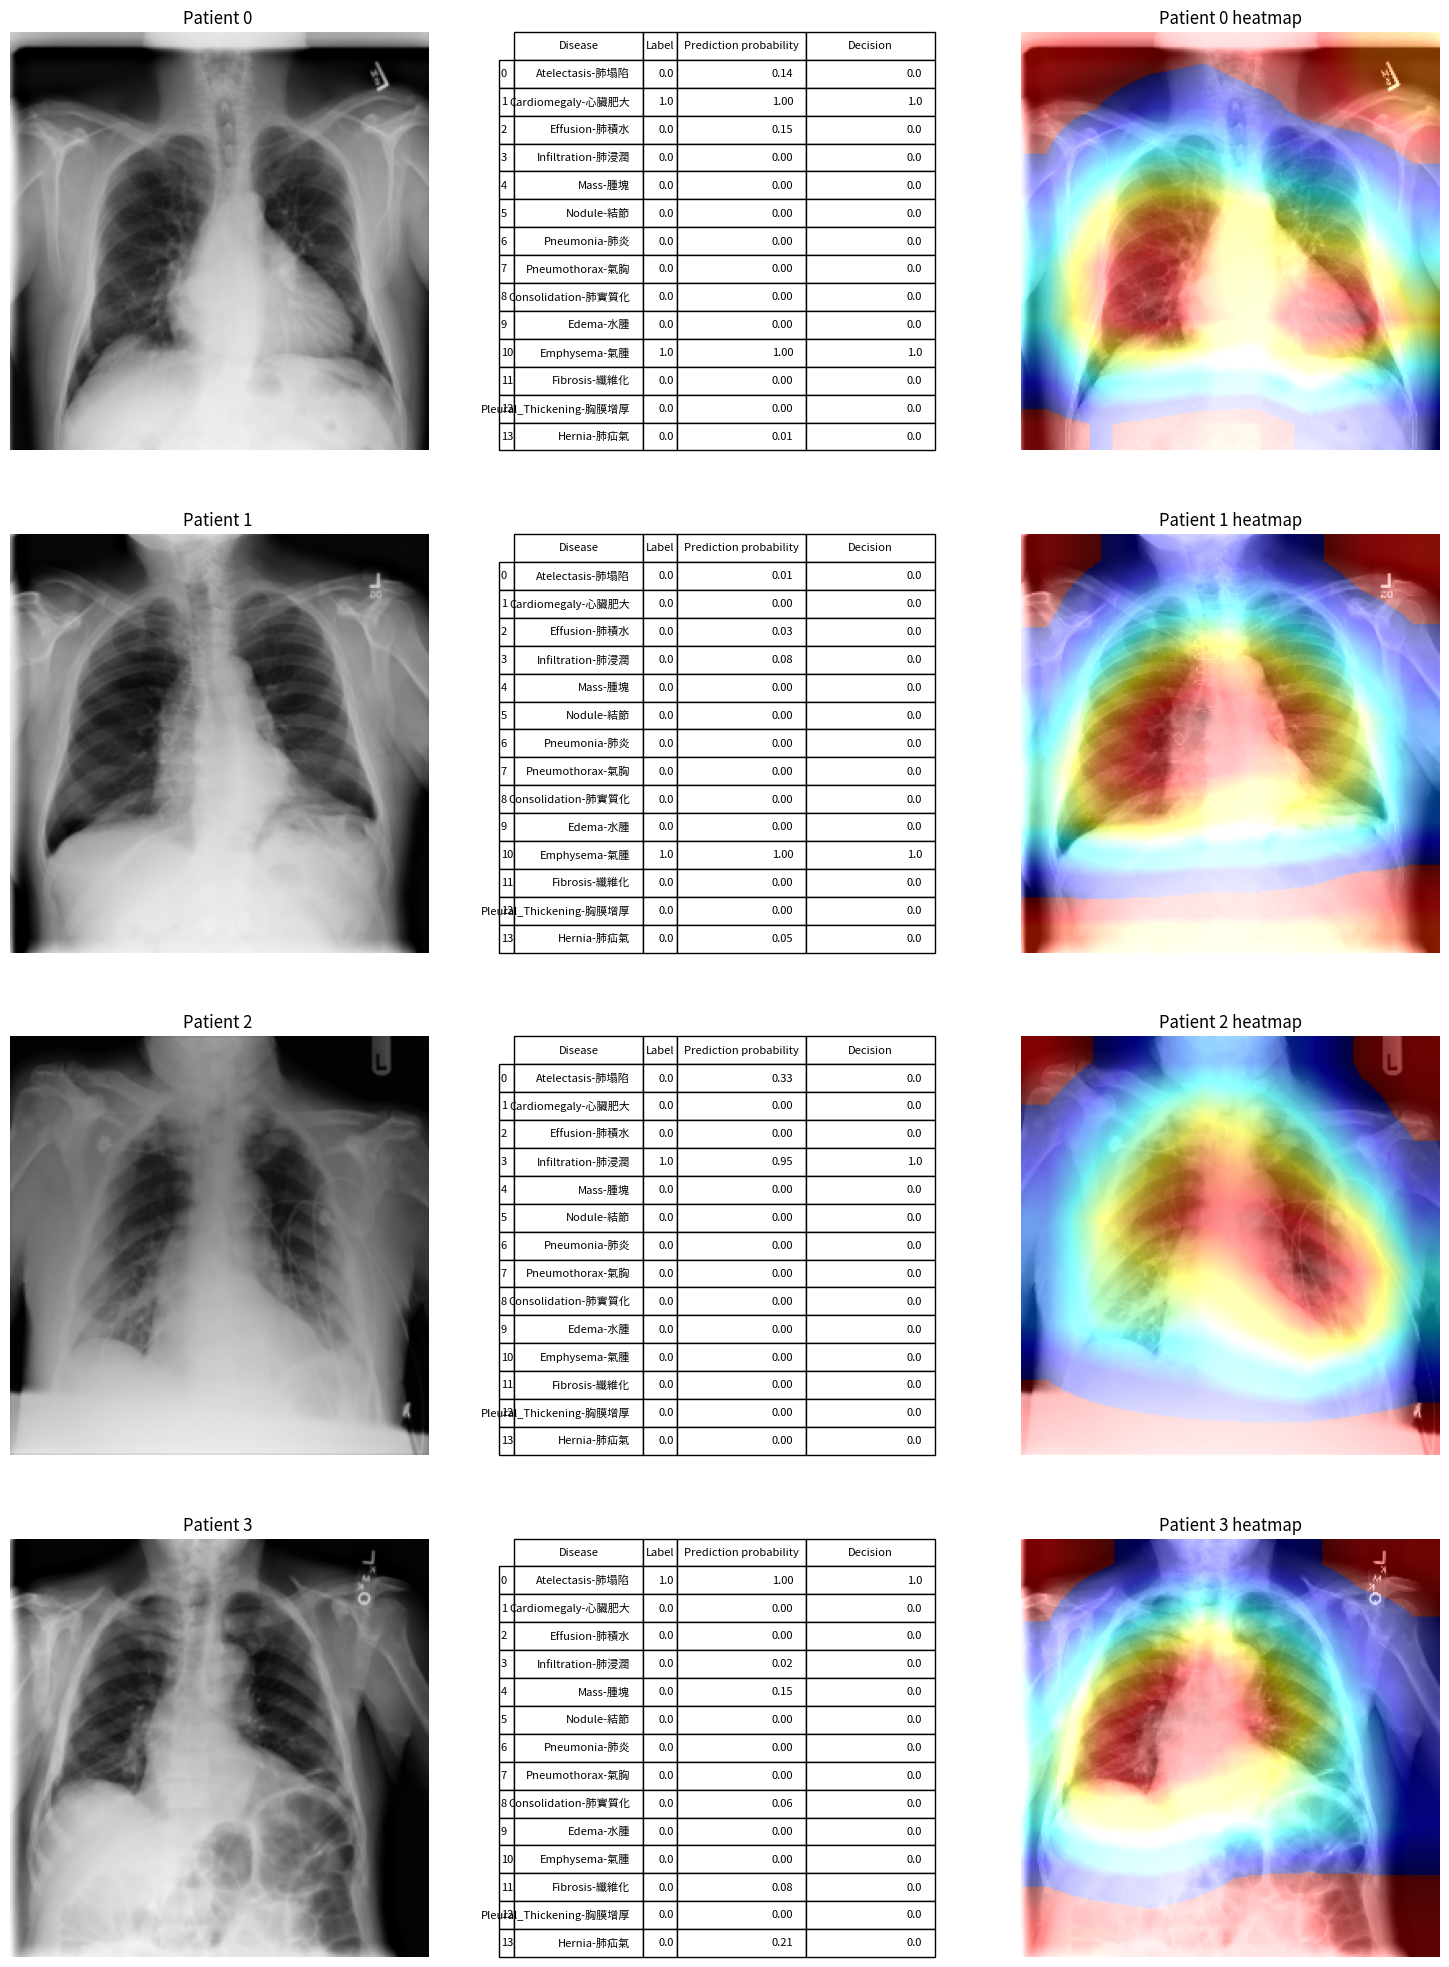

In [20]:
inference()